In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24})
import os
import pints
import pandas as pd
from experimental_data_processing import processingExperimentalData
from Newton_model_numba import wrappedNewton, newtonRaphsonFT

In [2]:
# base directory
base_directory = os.path.join('Data', 'processed')
base_directory = os.path.join(base_directory, '220415')
base_directory = os.path.join(base_directory, 'ph10 2m nacl 25oC')
# base_directory = os.path.join(base_directory, 'ac')
base_directory = os.path.join(base_directory, 'blank')
base_directory = os.path.join(base_directory, '9 150_1')
# base_directory = os.path.join(base_directory, '9_1b')

# reading in experimental data
input_data_file = os.path.join(base_directory, '9 150_1_cv_current')
#input_data_file = os.path.join(base_directory, '9_1b_cv_current')

# file for outut
output_data_file = os.path.join(base_directory, '9 150_1_cv_current_downsampled')
#output_data_file = os.path.join(base_directory, '9 150_1_cv_current_reduced')
#output_data_file = os.path.join(base_directory, '9_1b_cv_current_downsampled')
#output_data_file = os.path.join(base_directory, '9_1b_cv_current_reduced')

# frequency of experimental data
freq = 8.977950e+00

In [3]:
# creating instance of dataprocessing class
data_processing = processingExperimentalData(input_data_file)

# caculating number of periods in raw experimental data
x = data_processing.how_many_periods(data_processing.data, freq)
print('periods in untouched data: ', x)

# suggesting a number of rows to drop to make the sampled data closer to an intetger number of periods
rows_to_drop = data_processing.suggested_cut_for_periods(data_processing.data, freq)
print('\n\n suggested_cut_for_periods: ',rows_to_drop)

columnsnames:  Index(['time', 'current'], dtype='object')
periods in untouched data:  481.9998301065
measurements_per_period ~  4350.939292938392
rows dropped: 4341 updated_periods:  481.00229008199994
rows dropped: 4342 updated_periods:  481.002110523
rows dropped: 4343 updated_periods:  481.0018411845
rows dropped: 4344 updated_periods:  481.00157184600005
rows dropped: 4345 updated_periods:  481.001392287
rows dropped: 4346 updated_periods:  481.00112294850004
rows dropped: 4347 updated_periods:  481.0009433895
rows dropped: 4348 updated_periods:  481.00067405100003
rows dropped: 4349 updated_periods:  481.000494492
rows dropped: 4350 updated_periods:  481.0002251535001
rows dropped: 4351 updated_periods:  481.0000455945
rows dropped: 4352 updated_periods:  480.999776256


 suggested_cut_for_periods:  4351


In [4]:
# removing a number of rows to drop to make the sampled data closer to an intetger number of periods
row_to_drop = 0
cut_data = data_processing.cut_for_periods(data_processing.data, row_to_drop)
y = data_processing.how_many_periods(cut_data, freq)
print('periods in cut data: ', y)

# suggesting downsampling factors aiming for ~200 measurements per period
data_processing.suggested_measurements_reduction(cut_data, freq)

print('head: ', cut_data.head())
print('tail: ', cut_data.tail())
print('shape of data: ', cut_data.shape)

periods in cut data:  481.9998301065

********************
possible downsampling factors:
 [(1, 2097151.0), (7, 299593.0), (49, 42799.0), (127, 16513.0), (337, 6223.0), (889, 2359.0)]

 total measuremnts for 200 measurements per period:  96399.9660213 
********************
head:         time   current
0  0.000000  0.000004
1  0.000026  0.000016
2  0.000051  0.000016
3  0.000077  0.000024
4  0.000102  0.000027
tail:               time   current
2097147  53.68696  0.000075
2097148  53.68699  0.000079
2097149  53.68701  0.000073
2097150  53.68704  0.000085
2097151  53.68707  0.000018
shape of data:  (2097152, 2)


In [5]:
# downsampling data
reduction_factor = 7 # 22
reduced_by_class = data_processing.reducing_data(cut_data, reduction_factor)
print('head: ', reduced_by_class.head())
print('tail: ', reduced_by_class.tail())
dims = reduced_by_class.shape
print('shape of data: ', dims)
print('\nmeasurements per period', dims[0]/int(x))

# saving data
output_data_file = output_data_file + '_' + str(int(row_to_drop/reduction_factor))+'.txt'
data_processing.save_data(reduced_by_class, output_data_file)

head:          time   current
0   0.000000  0.000004
7   0.000179  0.000044
14  0.000358  0.000064
21  0.000538  0.000070
28  0.000717  0.000068
tail:               time   current
2097123  53.68635  0.000076
2097130  53.68653  0.000077
2097137  53.68671  0.000076
2097144  53.68689  0.000077
2097151  53.68707  0.000018
shape of data:  (299594, 2)

measurements per period 622.8565488565489


meausrements in both directions:  299594
meausrements in single direction:  149797


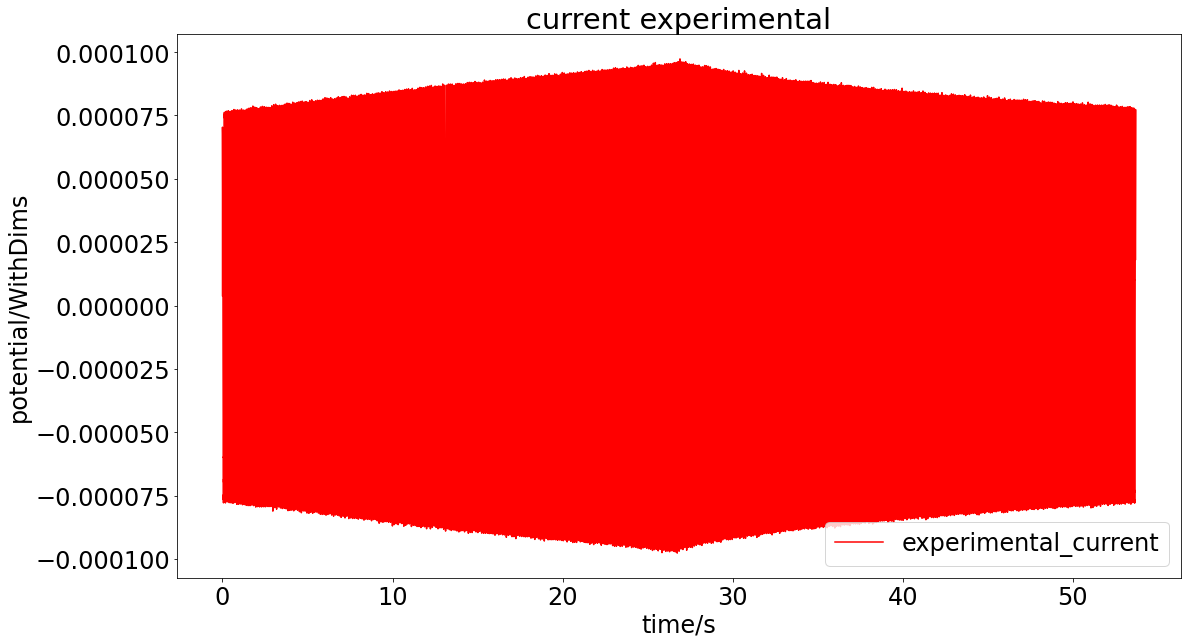

In [6]:
#checks and plot

exp_times = reduced_by_class.time
exp_times = np.asarray(exp_times)
exp_current = reduced_by_class.current
exp_current = np.asarray(exp_current)
measurements = reduced_by_class.shape[0]
print('meausrements in both directions: ', measurements)
measurements = int(measurements/2)
print('meausrements in single direction: ', measurements)

plt.figure(figsize=(18,10))
plt.title("current experimental")
plt.ylabel("potential/WithDims")
plt.xlabel("time/s")
plt.plot(exp_times, exp_current,'r', label='experimental_current')
plt.legend(loc='best')
#plt.yscale("log")
#plt.savefig('ac_current_pints.pdf')
plt.show()

In [7]:
# know paramteres if plotting fourier transform
# know paramteres for 9 150_1_cv_current_reduced_2
inital_current = exp_current[0]
freq = 8.977950e+00
startPotential= -300.0E-3
revPotential = -900.0E-3
rateOfPotentialChange = -22.35174e-3

deltaepislon = 150.0E-3
electrode_area = 0.03
electode_coverage = 6.5e-12

# delacring capactiance parameters
# (gamma0, gamma1, gamma2, gamma3, omega)
cap_params = (1.90549170481461828e-04, -2.09404340072224073e-04, -3.35917619947780804e-04, -2.31332466829235533e-04, -6.47034158535409176e+01)

uncomp_resis = 8.55110294972689928e+01


In [8]:
# declaring main model for manipulation purposes no symulations are done at this point
model = wrappedNewton(times = exp_times, inital_current=inital_current, freq=freq)

measurements = exp_current.shape[0]
print('measurements: ', measurements)
if measurements%2 !=0:
    print('*'*30+'\nerror must have evennumber of measurments\n'+'*'*40)

# declaring model to obtain non dimensinalise constant
trial = newtonRaphsonFT(timeStepSize=exp_times[1], inital_current=inital_current, freq=freq, startPotential= startPotential, revPotential = revPotential,
                        rateOfPotentialChange = rateOfPotentialChange, numberOfMeasurements = measurements, electrode_area=electrode_area, electode_coverage=electode_coverage)

# non-diming experimental data
exp_current_dimless = exp_current/trial.I0

# model = wrappedNewton(times = exp_times, inital_current=inital_current, freq=freq, startPotential= startPotential, revPotential = revPotential,
#                         rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon, electrode_area=electrode_area,
#                         electode_coverage=electode_coverage, initaldiscard = 0.0105, enddiscard = 0.9595, cap_params = cap_params, uncomp_resis = uncomp_resis)

model = wrappedNewton(times = exp_times, inital_current=inital_current, freq=freq, startPotential= startPotential, revPotential = revPotential,
                        rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon, electrode_area=electrode_area,
                        electode_coverage=electode_coverage, initaldiscard = 0.035, enddiscard = 0.87, cap_params = cap_params, uncomp_resis = uncomp_resis)

# model = wrappedNewton(times = exp_times, inital_current=inital_current, freq=freq, startPotential= startPotential, revPotential = revPotential,
#                         rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon, electrode_area=electrode_area,
#                         electode_coverage=electode_coverage, initaldiscard = 0.022, enddiscard = 0.915, cap_params = cap_params, uncomp_resis = uncomp_resis)

measurements:  299594


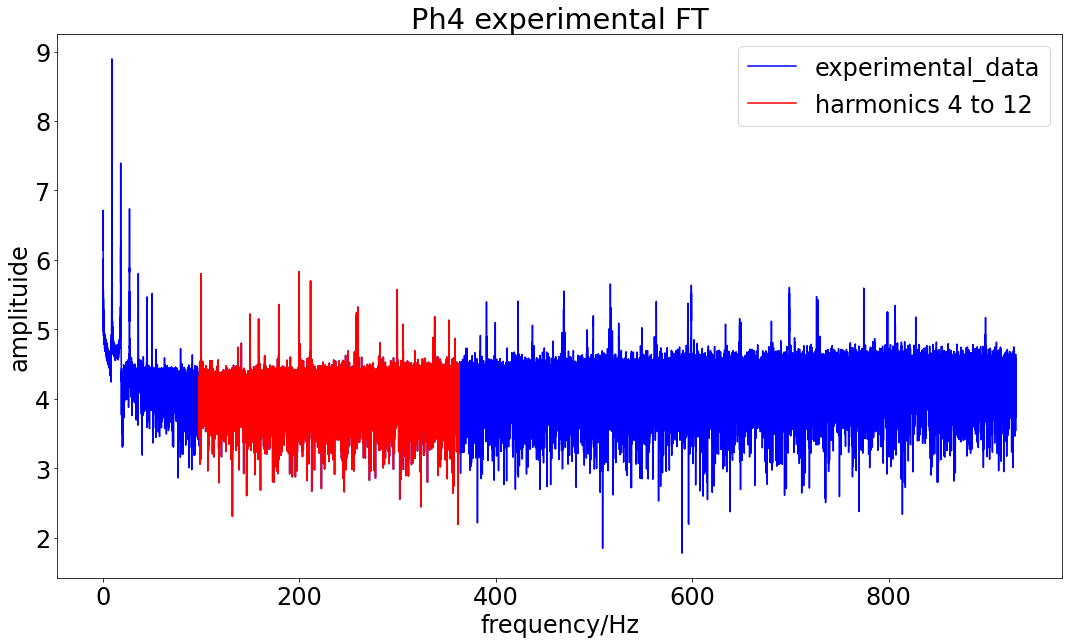

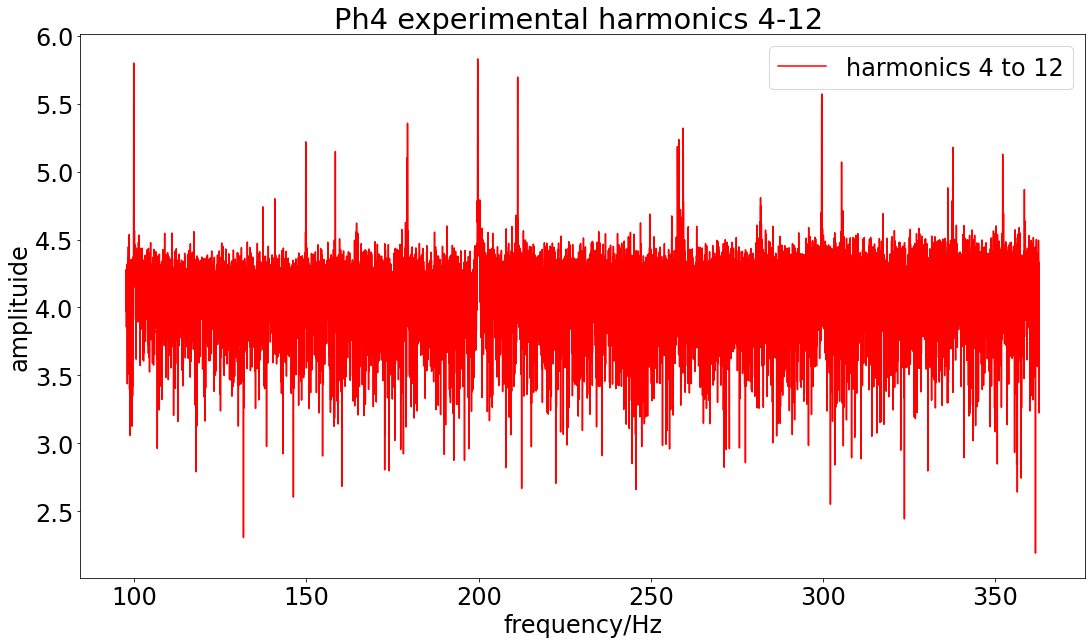

In [9]:
# checking loaction of harmonics 1-4
half_of_measuremnts = int(measurements/2)

# full FT and frequencies
full_sim = np.fft.fft(exp_current_dimless)
half_full_sim = full_sim[:half_of_measuremnts]

freq_org = np.fft.fftfreq(exp_times.shape[-1], d= exp_times[1])
freq_org=freq_org[:half_of_measuremnts]

# regional FT and Frequency

freq = model.frequencies_for_harmonics_4_to_12(exp_times)

harmonics1To4 = model.FT_and_reduce_to_harmonics_4_to_12(exp_current_dimless)

xaxislabel = "frequency/Hz" # "potential/V"
plt.figure(figsize=(18,10))
plt.title("Ph4 experimental FT")
plt.ylabel("amplituide")
plt.xlabel(xaxislabel)
plt.plot(freq_org[:int(half_of_measuremnts/3)], np.log10(half_full_sim[:int(half_of_measuremnts/3)]),'b', label='experimental_data')
plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
plt.legend(loc='best')
plt.show()

xaxislabel = "frequency/Hz" # "potential/V"
plt.figure(figsize=(18,10))
plt.title("Ph4 experimental harmonics 4-12 ")
plt.ylabel("amplituide")
plt.xlabel(xaxislabel)
plt.plot(freq, np.log10(harmonics1To4),'r', label='harmonics 4 to 12')
plt.legend(loc='best')
plt.show()

In [10]:
# checking harmonics are in the right place
real_parameters = model.suggested_parameter()
real_parameters = np.asarray(real_parameters)
real_parameters = [3.99999999999552711e+03,  3.99999999994729205e+03,
                   -5.89251115656171942e-01, -5.66887006363625101e-01,
                    5.62948703888808688e-02, 6.59850973035512989e-01]
print_all_harmonics = False
print_these_harmonics = [4,5,6,7,8,10,12,13]
model.ploting_harmonic(experimental_data = exp_current_dimless, times = exp_times, parameter_for_sim = real_parameters, Hz_interval = 0.60, print_all_harmonics= print_all_harmonics, print_these_harmonics = print_these_harmonics, check_FT_harmonic_locations = True, print_harmonics = True)